<a href="https://colab.research.google.com/github/edenlum/model_optimization/blob/pose-notebook/tutorials/notebooks/pytorch/ptq/pytorch_yolov8n_pose_for_imx500_no_eval1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8n Pose Estimation pytorch Model - Quantization for IMX500

[Run this tutorial in Google Colab](https://colab.research.google.com/github/sony/model_optimization/blob/main/tutorials/notebooks/keras/ptq/keras_yolov8n_for_imx500.ipynb)

## Overview

In this tutorial, we will illustrate a basic and quick process of preparing a pre-trained model for deployment using MCT. Specifically, we will demonstrate how to download a pre-trained YOLOv8n model from the MCT Models Library, compress it, and make it deployment-ready using MCT's post-training quantization techniques.

We will use an existing pre-trained YOLOv8n model based on [Ultralytics](https://github.com/ultralytics/ultralytics). The model was slightly adjusted to not include the box-decoding part. We will quantize the model using MCT post training quantization and evaluate the performance of the floating point model and the quantized model on COCO dataset.


## Summary

In this tutorial we will cover:

1. Post-Training Quantization using MCT of Keras object detection model.
2. Data preparation - loading and preprocessing validation and representative datasets from COCO.
3. Accuracy evaluation of the floating-point and the quantized models.

## Setup
### Install the relevant packages

In [1]:
!pip install -q tensorflow
!pip install -q pycocotools
!pip install -q onnx
!pip install -q ultralytics==8.0.232

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 8.2 MB/s eta 0:00:00


 Clone a copy of the [MCT](https://github.com/sony/model_optimization) (Model Compression Toolkit) into your current directory. This step ensures that you have access to [MCT Models Library](https://github.com/sony/model_optimization/tree/main/tutorials/mct_model_garden) folder which contains all the necessary utility functions for this tutorial.
  **It's important to note that we use the most up-to-date MCT code available.**

In [ ]:
!git clone https://github.com/edenlum/model_optimization.git local_mct
!pip install -q -r ./local_mct/requirements.txt
import sys
sys.path.insert(0,"./local_mct")

### Download COCO evaluation set

In [ ]:
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q -o annotations_trainval2017.zip -d ./coco
!echo Done loading annotations
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!unzip -q -o val2017.zip -d ./coco
!echo Done loading val2017 images

## Model Quantization

### Download a Pre-Trained Model

We begin by loading a pre-trained [YOLOv8n](https://huggingface.co/SSI-DNN/test_keras_yolov8n_640x640) model. This implementation is based on [Ultralytics](https://github.com/ultralytics/ultralytics) and includes a slightly modified version of yolov8 detection-head (mainly the box decoding part) that was adapted for model quantization. For further insights into the model's implementation details, please refer to [MCT Models Library - yolov8](https://github.com/sony/model_optimization/tree/main/tutorials/mct_model_garden/models_keras/yolov8).   

Download the model's weights from ultralytics

In [ ]:
!wget -nc https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-pose.pt

In [5]:
!git clone https://github.com/sony/custom_layers.git
sys.path.insert(0,"./custom_layers")

Cloning into 'custom_layers'...
remote: Enumerating objects: 684, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 684 (delta 121), reused 116 (delta 113), pack-reused 515
Receiving objects: 100% (684/684), 156.96 KiB | 5.23 MiB/s, done.
Resolving deltas: 100% (355/355), done.


Load the model, and the load the weights into it

In [ ]:
import importlib
import tutorials
import torch

from tutorials.mct_model_garden.models_pytorch.yolov8.yolov8 import yolov8_pytorch

float_model, cfg = yolov8_pytorch("./local_mct/tutorials/mct_model_garden/models_pytorch/yolov8/yolov8-pose.yaml")

org_dict = torch.load("./yolov8n-pose.pt")
float_model.load_state_dict(org_dict['model'].state_dict(), strict=False)

### Post training quantization using Model Compression Toolkit

Now, we're all set to use MCT's post-training quantization. To begin, we'll define a representative dataset and proceed with the model quantization. Please note that, for demonstration purposes, we'll use the evaluation dataset as our representative dataset. We'll calibrate the model using 100 representative images, divided into 20 iterations of 'batch_size' images each.

Additionally, to further compress the model's memory footprint, we will employ the mixed-precision quantization technique. This method allows each layer to be quantized with different precision options: 2, 4, and 8 bits, aligning with the imx500 target platform capabilities.

In [ ]:
import model_compression_toolkit as mct
from tutorials.mct_model_garden.evaluation_metrics.coco_evaluation import coco_dataset_generator
from tutorials.mct_model_garden.models_keras.yolov8.yolov8_preprocess import yolov8_preprocess_chw_transpose
from typing import Iterator, Tuple, List

REPRESENTATIVE_DATASET_FOLDER = './coco/val2017/'
REPRESENTATIVE_DATASET_ANNOTATION_FILE = './coco/annotations/person_keypoints_val2017.json'
BATCH_SIZE = 5
n_iters = 20

# Load representative dataset
representative_dataset = coco_dataset_generator(dataset_folder=REPRESENTATIVE_DATASET_FOLDER,
                                                annotation_file=REPRESENTATIVE_DATASET_ANNOTATION_FILE,
                                                preprocess=yolov8_preprocess_chw_transpose,
                                                batch_size=BATCH_SIZE)

# Define representative dataset generator
def get_representative_dataset(n_iter: int, dataset_loader: Iterator[Tuple]):
    """
    This function creates a representative dataset generator. The generator yields numpy
        arrays of batches of shape: [Batch, H, W ,C].
    Args:
        n_iter: number of iterations for MCT to calibrate on
    Returns:
        A representative dataset generator
    """
    def representative_dataset() -> Iterator[List]:
        ds_iter = iter(dataset_loader)
        for _ in range(n_iter):
            yield [next(ds_iter)[0]]

    return representative_dataset

# Get representative dataset generator
representative_dataset_gen = get_representative_dataset(n_iters, representative_dataset)

# Set IMX500-v1 TPC
tpc = mct.get_target_platform_capabilities("pytorch", 'imx500', target_platform_version='v1')

# Specify the necessary configuration for mixed precision quantization. To keep the tutorial brief, we'll use a small set of images and omit the hessian metric for mixed precision calculations. It's important to be aware that this choice may impact the resulting accuracy.
mp_config = mct.core.MixedPrecisionQuantizationConfig(num_of_images=5, use_hessian_based_scores=False)
config = mct.core.CoreConfig(mixed_precision_config=mp_config,
                             quantization_config=mct.core.QuantizationConfig(shift_negative_activation_correction=True))

# Define target Resource Utilization for mixed precision weights quantization (75% of 'standard' 8bits quantization)
resource_utilization_data = mct.core.pytorch_resource_utilization_data(float_model,
                                   representative_dataset_gen,
                                   config,
                                   target_platform_capabilities=tpc)
print("float model weights memory: ", resource_utilization_data.weights_memory)
resource_utilization = mct.core.ResourceUtilization(resource_utilization_data.weights_memory * 0.75)

# Perform post training quantization
quant_model, _ = mct.ptq.pytorch_post_training_quantization(float_model,
                                                          representative_dataset_gen,
                                                          target_resource_utilization=resource_utilization,
                                                          core_config=config,
                                                          target_platform_capabilities=tpc)
print('Quantized model is ready')

## Post Processing for Pose Estimation

In [59]:
from enum import Enum
from typing import List, Tuple
import numpy as np


def postprocess_yolov8(outputs: Tuple[np.ndarray, np.ndarray, np.ndarray],
                       conf: float = 0.001,
                       iou_thres: float = 0.7,
                       max_out_dets: int = 300) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Postprocess the outputs of a YOLOv8 model for object detection and pose estimation.

    Args:
        outputs (Tuple[np.ndarray, np.ndarray, np.ndarray]): Tuple containing the model outputs for bounding boxes,
            class predictions, and keypoint predictions.
        conf (float, optional): Confidence threshold for bounding box predictions. Default is 0.001.
        iou_thres (float, optional): IoU (Intersection over Union) threshold for Non-Maximum Suppression (NMS).
            Default is 0.7.
        max_out_dets (int, optional): Maximum number of output detections to keep after NMS. Default is 300.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Tuple containing the post-processed bounding boxes,
            their corresponding scores, and keypoints.

    """
    kpt_shape = (17, 3)
    feat_sizes = np.array([80, 40, 20])
    stride_sizes = np.array([8, 16, 32])
    a, s = (x.transpose() for x in make_anchors_yolo_v8(feat_sizes, stride_sizes, 0.5))

    y_bb, y_cls, kpts = outputs
    # Decode bbox. we assume batch dimension of 1 for each array
    if len(y_bb.shape) < 3:
        y_bb, y_cls, kpts = np.expand_dims(y_bb, 0), np.expand_dims(y_cls, 0), np.expand_dims(kpts, 0)
    y_bb = y_bb.transpose(0, 2, 1)
    y_cls = y_cls.transpose(0, 2, 1)

    dbox = dist2bbox_yolo_v8(y_bb, a, xywh=True, dim=1) * s
    detect_out = np.concatenate((dbox, y_cls), 1)
    # additional part for pose estimation
    ndim = kpt_shape[1]
    pred_kpt = kpts.copy()
    if ndim == 3:
        pred_kpt[:, 2::3] = 1 / (1 + np.exp(-pred_kpt[:, 2::3]))  # sigmoid (WARNING: inplace .sigmoid_() Apple MPS bug)
    pred_kpt[:, 0::ndim] = (pred_kpt[:, 0::ndim] * 2.0 + (a[0] - 0.5)) * s
    pred_kpt[:, 1::ndim] = (pred_kpt[:, 1::ndim] * 2.0 + (a[1] - 0.5)) * s

    x = np.concatenate([detect_out.transpose([2, 1, 0]).squeeze(), pred_kpt.transpose([2, 1, 0]).squeeze()], 1)
    x = x[(x[:, 4] > conf)]
    x = x[np.argsort(-x[:, 4])[:8400]]
    x[..., :4] = convert_to_ymin_xmin_ymax_xmax_format(x[..., :4], BoxFormat.XMIM_YMIN_XMAX_YMAX)
    boxes = x[..., :4]
    scores = x[..., 4]

    # Original post-processing part
    valid_indexs = nms(boxes, scores, iou_thres=iou_thres, max_out_dets=max_out_dets)
    x = x[valid_indexs]
    nms_bbox = x[:, :4]
    nms_scores = x[:, 4]
    nms_kpts = x[:, 5:]

    return nms_bbox, nms_scores, nms_kpts

def nms(dets: np.ndarray, scores: np.ndarray, iou_thres: float = 0.5, max_out_dets: int = 300) -> List[int]:
    """
    Perform Non-Maximum Suppression (NMS) on detected bounding boxes.

    Args:
        dets (np.ndarray): Array of bounding box coordinates of shape (N, 4) representing [y1, x1, y2, x2].
        scores (np.ndarray): Array of confidence scores associated with each bounding box.
        iou_thres (float, optional): IoU threshold for NMS. Default is 0.5.
        max_out_dets (int, optional): Maximum number of output detections to keep. Default is 300.

    Returns:
        List[int]: List of indices representing the indices of the bounding boxes to keep after NMS.

    """
    y1, x1 = dets[:, 0], dets[:, 1]
    y2, x2 = dets[:, 2], dets[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thres)[0]
        order = order[inds + 1]

    return keep[:max_out_dets]

def make_anchors_yolo_v8(feats, strides, grid_cell_offset=0.5):
    """Generate anchors from features."""
    anchor_points, stride_tensor = [], []
    assert feats is not None
    for i, stride in enumerate(strides):
        h, w = feats[i], feats[i]
        sx = np.arange(stop=w) + grid_cell_offset  # shift x
        sy = np.arange(stop=h) + grid_cell_offset  # shift y
        sy, sx = np.meshgrid(sy, sx, indexing='ij')
        anchor_points.append(np.stack((sx, sy), -1).reshape((-1, 2)))
        stride_tensor.append(np.full((h * w, 1), stride))
    return np.concatenate(anchor_points), np.concatenate(stride_tensor)


def dist2bbox_yolo_v8(distance, anchor_points, xywh=True, dim=-1):
    """Transform distance(ltrb) to box(xywh or xyxy)."""
    lt, rb = np.split(distance,2,axis=dim)
    x1y1 = anchor_points - lt
    x2y2 = anchor_points + rb
    if xywh:
        c_xy = (x1y1 + x2y2) / 2
        wh = x2y2 - x1y1
        return np.concatenate((c_xy, wh), dim)  # xywh bbox
    return np.concatenate((x1y1, x2y2), dim)  # xyxy bbox


class BoxFormat(Enum):
    YMIM_XMIN_YMAX_XMAX = 'ymin_xmin_ymax_xmax'
    XMIM_YMIN_XMAX_YMAX = 'xmin_ymin_xmax_ymax'
    XMIN_YMIN_W_H = 'xmin_ymin_width_height'
    XC_YC_W_H = 'xc_yc_width_height'


def convert_to_ymin_xmin_ymax_xmax_format(boxes, orig_format: BoxFormat):
    """
    changes the box from one format to another (XMIN_YMIN_W_H --> YMIM_XMIN_YMAX_XMAX )
    also support in same format mode (returns the same format)

    :param boxes:
    :param orig_format:
    :return: box in format YMIM_XMIN_YMAX_XMAX
    """
    if len(boxes) == 0:
        return boxes
    elif orig_format == BoxFormat.YMIM_XMIN_YMAX_XMAX:
        return boxes
    elif orig_format == BoxFormat.XMIN_YMIN_W_H:
        boxes[:, 2] += boxes[:, 0]  # convert width to xmax
        boxes[:, 3] += boxes[:, 1]  # convert height to ymax
        boxes[:, 0], boxes[:, 1] = boxes[:, 1], boxes[:, 0].copy()  # swap xmin, ymin columns
        boxes[:, 2], boxes[:, 3] = boxes[:, 3], boxes[:, 2].copy()  # swap xmax, ymax columns
        return boxes
    elif orig_format == BoxFormat.XMIM_YMIN_XMAX_YMAX:
        boxes[:, 0], boxes[:, 1] = boxes[:, 1], boxes[:, 0].copy()  # swap xmin, ymin columns
        boxes[:, 2], boxes[:, 3] = boxes[:, 3], boxes[:, 2].copy()  # swap xmax, ymax columns
        return boxes
    elif orig_format == BoxFormat.XC_YC_W_H:
        new_boxes = np.copy(boxes)
        new_boxes[:, 0] = boxes[:, 1] - boxes[:, 3] / 2  # top left y
        new_boxes[:, 1] = boxes[:, 0] - boxes[:, 2] / 2  # top left x
        new_boxes[:, 2] = boxes[:, 1] + boxes[:, 3] / 2  # bottom right y
        new_boxes[:, 3] = boxes[:, 0] + boxes[:, 2] / 2  # bottom right x
        return new_boxes
    else:
        raise Exception("Unsupported boxes format")


## Run model and plot the results

In [67]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_image_with_pose_plt(image_tensor, boxes, confs, kpts, ax):
    # Assuming image_tensor is in the shape (1, 3, 640, 640) and normalized
    image = image_tensor.squeeze(0).transpose(1, 2, 0)  # Reshape to (640, 640, 3)
    ax.imshow(image)

    # Skeleton connections for COCO keypoints
    skeleton = [
        (15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6),
        (5, 7), (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4),
        (3, 5), (4, 6)
    ]

    # Iterate over pose predictions
    for box_coords, conf, keypoints in zip(boxes, confs, kpts):
        keypoints = keypoints.reshape(-1, 3)  # Reshape from flat (51) to (17, 3) [x, y, visible]
        if conf < 0.55:
            continue

        # Convert box coordinates (assuming normalized between 0 and 1)
        yc, xc, height, width = box_coords
        print(box_coords)

        # Draw the bounding box
        rect = plt.Rectangle((xc-width//2, yc-height//2), width, height, fill=False, color='green', linewidth=2)
        ax.add_patch(rect)

        # Draw keypoints
        visible_keypoints = []
        for x, y, visibility in keypoints:
            if visibility.item() > 0.5:
                circle = plt.Circle((x, y), radius=3, color='red')
                ax.add_patch(circle)
                visible_keypoints.append((x, y))

        # Draw skeleton
        for start, end in skeleton:
            if keypoints[start, 2].item() > 0.5 and keypoints[end, 2].item() > 0.5:
                start_coords = (keypoints[start, 0], keypoints[start, 1])
                end_coords = (keypoints[end, 0], keypoints[end, 1])
                ax.plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]], 'r-', linewidth=1)
        break


[     498.36      501.13       48.71      53.148]
[     467.55       341.2       33.75      43.086]
[     467.75         373        33.5          43]
[     242.78      342.77      32.668      27.557]
[     437.75      537.12          53       34.75]
[     465.81      533.12      51.054      44.741]
[     445.12      312.62       32.25       37.75]
[     469.33      499.53      49.249      47.068]


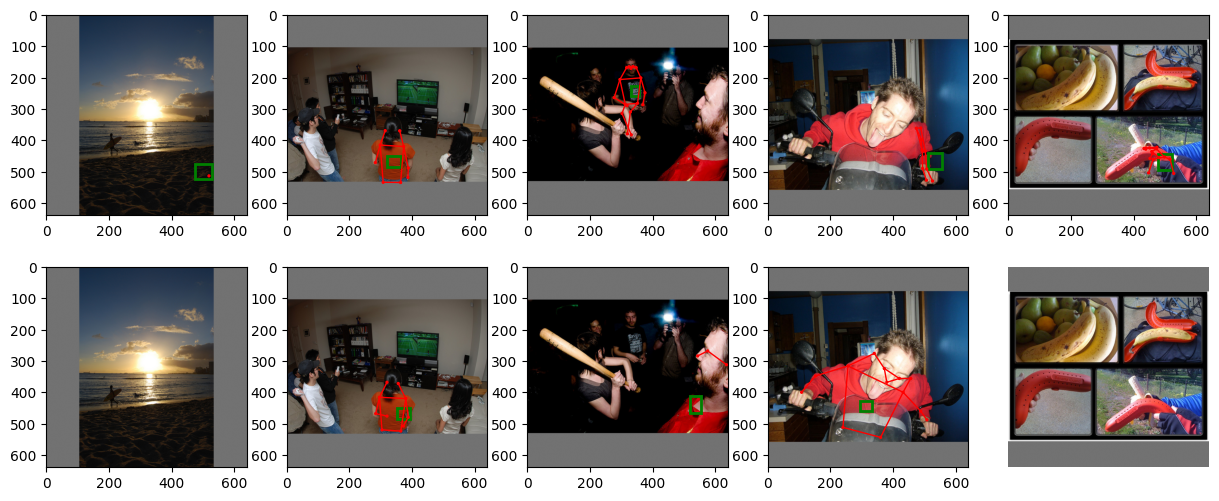

In [68]:
import matplotlib.pyplot as plt
from torch import Tensor

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for i, b in enumerate(representative_dataset_gen()):
    if i >= 5:
        break

    # convert to Tensor and take the first sample in the batch
    img = b[0][:1]
    x = Tensor(img).to(device)
    # Float model
    float_model = float_model.to(device)
    res = float_model(x)
    res_pp = postprocess_yolov8([r.cpu().detach().numpy() for r in res])
    plot_image_with_pose_plt(img, *res_pp, ax=axes[0, i])

    # Quant model
    quant_model = quant_model.to(device)
    res = quant_model(x)
    res_pp = postprocess_yolov8([r.cpu().detach().numpy() for r in res])
    plot_image_with_pose_plt(img, *res_pp, ax=axes[1, i])

plt.axis("off")
plt.show()

\
Copyright 2024 Sony Semiconductor Israel, Inc. All rights reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.